In [60]:
#loading dependencies
import numpy as np
import math
from pprint import pprint
import random
import operator
%matplotlib inline
import matplotlib as mpl

import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import matplotlib #only needed to determine Matplotlib version number

from os import listdir
from os.path import isfile, join
import csv

import folium
from IPython.display import HTML,IFrame

import datetime

In [157]:
def to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H:%M:%S')

def load_data(path):   
    # ==> Loading Merged Station Data
    data = pd.read_json(path)
    # ==> Converting timestamp to pandas timestamp datatype
    data['last_update'] = data['last_update'].map(to_datetime)
    data['last_update'] = pd.to_datetime(data['last_update'])
    # ==> Rebuilding Multiindex
    data.set_index(["number",'last_update'],inplace=True,drop=True)
    # ==> Sort index by number & timestamp
    data.sort_index(inplace=True)
    return data

In [158]:
data = load_data('challenge_data/stations_merged.json')

##### Null Data ?
The dataset does not include any N/A datapoint

In [166]:
data.isnull().sum()

address                  0
available_bike_stands    0
available_bikes          0
banking                  0
bike_stands              0
bonus                    0
contract_name            0
index                    0
lat                      0
lng                      0
name                     0
status                   0
dtype: int64

### Static Data

- ```number``` le numéro de la station. Attention, ce n'est pas un id, ce numéro n'est unique qu'au sein d'un contrat
- ```contract_name``` le nom du contrat de cette station
- ```name``` le nom de la station
- ```address``` adresse indicative de la station, les données étant brutes, parfois il s'agit plus d'un commentaire que d'une adresse.
- ```position``` les coordonnées au format WGS84
- ```banking``` indique la présence d'un terminal de paiement
- ```bonus``` indique s'il s'agit d'une station bonus
- ```bike_stands``` is also considered static on the data set

In [167]:
# ==> Building Station-related infos
stations = data.groupby(level = "number").first()
stations = stations[["bike_stands","name","address","lat","lng",'banking','bonus']]
stations.head()

,bike_stands,name,address,lat,lng,banking,bonus
number,,,,,,,
1010,25,01010 - PONT NEUF,10 RUE BOUCHER - 75001 PARIS,48.859462,2.344366,True,False
1012,22,01012 - BOURSE DU COMMERCE,FACE 29 RUE JEAN JACQUES ROUSSEAU - 75001 PARIS,48.862998,2.341555,True,False
1013,66,01013 - SAINT HONORE,186 RUE SAINT HONORE - 75001 PARIS,48.862430,2.338520,True,False
1014,25,01014 - RIVOLI MUSEE DU LOUVRE,5 RUE DE L'ECHELLE - 75001 PARIS,48.863672,2.334058,True,False
1015,20,01015 - PLACE ANDRE MALRAUX,2 PLACE ANDRE MALRAUX - 75001 PARIS,48.863980,2.335600,True,False


#### Number, contract_name, name and address
N/A


#### Bike Stands
=> Very diverse number of stands depending on station type
=> Predicting the number of available bikes might be dangerous

In [168]:
bike_stands = data.groupby(level=['number']).agg({'bike_stands':[np.min,np.max]})
bike_stands.columns = bike_stands.columns.droplevel()
bike_stands["is_static"] = bike_stands["amin"] == bike_stands["amax"]
bike_stands["is_static"].value_counts()
# => bike_stands do not evolve across time, considered a static variable

True    45
Name: is_static, dtype: int64

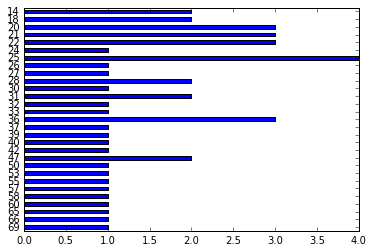

In [169]:
stations["bike_stands"].value_counts().sort_index(ascending=False).plot(kind='barh')

In [170]:
def build_folium_map(stations,radius_metric,popup_col,map_path,radius_factor=2):
    # ==> Center position for the Map
    location_center = data[["lat",'lng']].mean().tolist()
    print location_center
    # ==> Building the Map
    paris_map = folium.Map(location=location_center,zoom_start=13, tiles='Stamen Toner')
    # ==> Adding Stations
    for (i,el) in stations.iterrows():
        folium.CircleMarker([el["lat"], el["lng"]],radius=el[radius_metric]*radius_factor,popup= el[popup_col],color='#3186cc',fill_color='#3186cc').add_to(paris_map) 
    # ==> Saving to html file
    paris_map.create_map(path=map_path)
    
# ==> Displaying html file in Iframe
build_folium_map(stations,'bike_stands','name','graphs/bike_stands_stations.html')
IFrame('graphs/bike_stands_stations.html', width=700, height=350)

[48.858663181591702, 2.331525463802405]


/Users/davidleroy/Documents/snips/venv/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: Map.create_map is deprecated. Use Map.save instead


#### Location
Only three districs, the 1st, 4th and 7th

In [171]:
import re

def get_district(address):
    m = re.search('.*(\d{5}).*', address)
    if m:
        found = m.group(1)
        return found[-2:]
    
stations["district"] = stations["address"].map(get_district)

In [172]:
stations["district"].value_counts()

07    17
01    16
04    12
Name: district, dtype: int64

#### Bonus Stations
All stations are not bonus => could have been a good proxy for elevation

In [173]:
stations["bonus"].value_counts()

False    45
Name: bonus, dtype: int64

#### Banking Stations
All station have a payment facility => not discriminatory

In [174]:
stations["banking"].value_counts()

True    45
Name: banking, dtype: int64

## About static data: key learnings

- ```banking``` and  ```bonus``` columns can be removed since they do not provide any info
- stations provided have a very diverse ```bike_stands```
- only three districts are covered, the 1st,

In [175]:
del data["banking"]
del data["bonus"]

## Dynamic Data
- ```status``` indique l'état de la station, peut être CLOSED ou OPEN
- ```bike_stands``` le nombre de points d'attache opérationnels
- ```available_bike_stands``` le nombre de points d'attache disponibles pour y ranger un vélo
- ```available_bikes``` le nombre de vélos disponibles et opérationnels
- ```last_update``` timestamp indiquant le moment de la dernière mise à jour en millisecondes depuis Epoch

#### Understanding time indexing in data

In [211]:
#### Looking at the time range
date_range  = data.reset_index(level ='last_update').groupby(level='number').agg({'last_update':[np.min,np.max],'name':len})
date_range.head()

name         last_update                    
          len                amin                amax
number                                               
1010    15850 2015-09-01 01:51:43 2015-12-01 00:46:38
1012    16230 2015-09-01 01:52:59 2015-12-01 00:46:28
1013    18618 2015-09-01 01:49:03 2015-12-01 00:51:08
1014    15583 2015-09-01 01:51:24 2015-11-30 22:25:03
1015    17592 2015-09-01 01:51:12 2015-12-01 00:46:22

In [212]:
#### Start datetime
print 'Min Start Date %s' % date_range[("last_update",'amin')].min()
print 'Max Start Date %s' % date_range[("last_update",'amin')].max()

Min Start Date 2015-09-01 01:49:03
Max Start Date 2015-09-01 01:59:04


In [213]:
#### End datetime
print 'Min End Date %s' % date_range[("last_update",'amax')].min()
print 'Max End Date %s' % date_range[("last_update",'amax')].max()

Min End Date 2015-11-30 22:25:03
Max End Date 2015-12-01 00:54:43


Min range of days 90.8567013889
Max range of days 90.9618171296


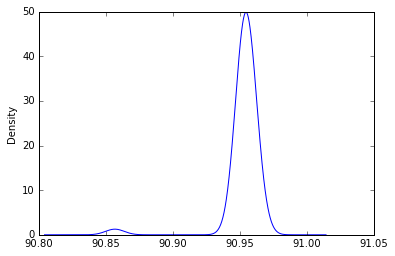

In [214]:
#### Number of Days
date_range["day_range"] = (date_range[('last_update','amax')] - date_range[('last_update','amin')])
date_range["day_range"] = date_range["day_range"].dt.total_seconds()/(3600*24)
date_range["day_range"].plot(kind='density')
print 'Min range of days %s' % date_range["day_range"].min()
print 'Max range of days %s' % date_range["day_range"].max()

=> Range covered accross stations is stable

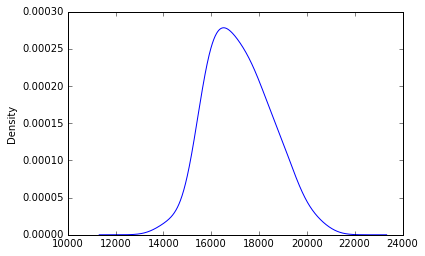

In [215]:
##### Number of Data Points
date_range[('name','len')].plot(kind='density')

=> Time series are irregular

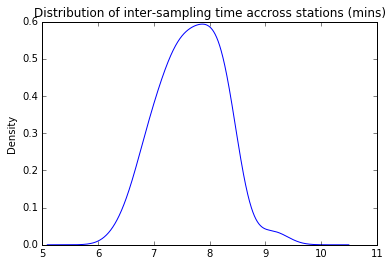

In [223]:
date_range["mean_freq"] =  date_range['day_range']/ date_range[("name","len")]*(24*60)
date_range["mean_freq"].plot(kind='density',title='Distribution of inter-sampling time accross stations (mins)')

In [268]:
data = data.reset_index()


In [270]:
del data["level_0"]
data.head()

,last_update,number,address,available_bike_stands,available_bikes,bike_stands,contract_name,index,lat,lng,name,status
0,2015-09-01 01:51:43,1010,10 RUE BOUCHER - 75001 PARIS,25,0,25,Paris,14015,48.859462,2.344366,01010 - PONT NEUF,OPEN
1,2015-09-01 02:01:47,1010,10 RUE BOUCHER - 75001 PARIS,25,0,25,Paris,7503,48.859462,2.344366,01010 - PONT NEUF,OPEN
2,2015-09-01 02:11:50,1010,10 RUE BOUCHER - 75001 PARIS,25,0,25,Paris,12609,48.859462,2.344366,01010 - PONT NEUF,OPEN
3,2015-09-01 02:21:53,1010,10 RUE BOUCHER - 75001 PARIS,25,0,25,Paris,557,48.859462,2.344366,01010 - PONT NEUF,OPEN
4,2015-09-01 02:31:57,1010,10 RUE BOUCHER - 75001 PARIS,25,0,25,Paris,10262,48.859462,2.344366,01010 - PONT NEUF,OPEN


In [318]:
bs_by_station = data.pivot_table(index='last_update', columns='number', values='available_bike_stands',aggfunc= np.mean)

In [319]:
bs_by_station.head()

number,1010,1012,1013,1014,1015,1016,1017,1018,1019,1020,...,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026
last_update,,,,,,,,,,,,,,,,,,,,,
2015-09-01 01:49:03,NaN,NaN,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-01 01:49:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-01 01:49:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-01 01:49:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-01 01:49:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


In [320]:
bs_by_station_30min = bs_by_station.resample('30min').mean() #.ffill()

In [321]:
bs_by_station_30min.head()

number,1010,1012,1013,1014,1015,1016,1017,1018,1019,1020,...,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026
last_update,,,,,,,,,,,,,,,,,,,,,
2015-09-01 01:30:00,25.0,21.0,64.0,24.0,19.0,20.0,17.0,20.0,12.0,34.0,...,26.000000,3.0,19.000000,14.0,5.000000,64.0,19.000000,10.000000,19.000000,21.000000
2015-09-01 02:00:00,25.0,21.0,64.0,24.0,19.0,20.5,16.0,20.0,12.0,34.0,...,26.750000,3.0,20.166667,14.0,5.000000,64.0,20.500000,9.333333,19.333333,21.000000
2015-09-01 02:30:00,25.0,21.0,64.0,24.0,19.0,22.0,16.0,19.5,12.0,34.0,...,26.000000,3.0,21.000000,14.0,5.000000,64.0,35.666667,8.000000,20.000000,21.000000
2015-09-01 03:00:00,25.0,21.0,64.0,24.0,19.0,22.0,16.0,19.0,12.0,34.0,...,26.000000,3.0,21.200000,14.0,4.333333,64.0,40.000000,9.000000,19.750000,21.333333
2015-09-01 03:30:00,25.0,21.0,64.0,24.0,19.0,22.0,16.0,19.0,12.0,34.0,...,25.666667,3.0,22.000000,14.0,7.250000,64.0,41.000000,8.666667,19.000000,22.000000


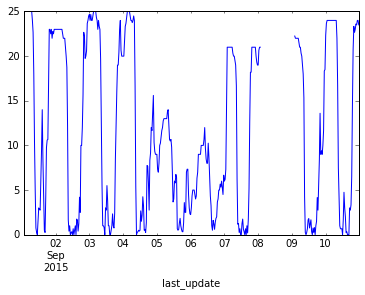

In [330]:
bs_by_station_30min.loc['09/01/2015':'09/10/2015',1010].plot()